# Object analysis by user precise

In [7]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate
from scipy.stats import zscore

conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryData = """SELECT
               DistancesPerTestCasePrecise.Username,
               DistancesPerTestCasePrecise.UserID,
               DistancesPerTestCasePrecise.ScenarioCase,
               DistancesPerTestCasePrecise.TestCaseID,
               DistancesPerTestCasePrecise.TestCaseName,
               DistancesPerTestCasePrecise.Position,
               DistancesPerTestCasePrecise.CameraDistance,
               DistancesPerTestCasePrecise.ObjectDistance,
               DistancesPerTestCasePrecise.DistanceFinished,
               ((0.1-DistancesPerTestCasePrecise.DistanceFinished)/ObjectDistance) AS PerformanceGeneral,
               Duration
               FROM DistancesPerTestCasePrecise
               RIGHT JOIN TestCaseData
               ON DistancesPerTestCasePrecise.TestCaseID = TestCaseData.TestCaseID;"""

observed_group = "UserID"
tested_variable = 'PerformanceGeneral'

Data = pd.read_sql_query(queryData, conn)
DataAverageAggregated = Data.groupby([observed_group, 'ScenarioCase'])[['ObjectDistance', 'DistanceFinished', 'PerformanceGeneral']].mean().reset_index()

DataAverageAggregated[f'{tested_variable}_z_within'] = DataAverageAggregated.groupby('ScenarioCase')[tested_variable].transform(zscore)

for data in DataAverageAggregated[f'{tested_variable}_z_within']:
    if data >= 2.5 or data <= -2.5:
        print(f"Significant outlier {data}")

    ScenarioCase  count      mean       std       min       25%       50%  \
0         FOLDAR   12.0  0.217637  0.063768  0.077517  0.174382  0.227523   
1     FOLDAROPEN   12.0  0.196471  0.086084  0.068937  0.158259  0.197689   
2  STATEOFTHEART   12.0  0.289443  0.082966  0.175834  0.230407  0.279472   

        75%       max  ObjectDistance  
0  0.270130  0.289549        0.673046  
1  0.234837  0.395046        0.897615  
2  0.368330  0.407963        0.367058  


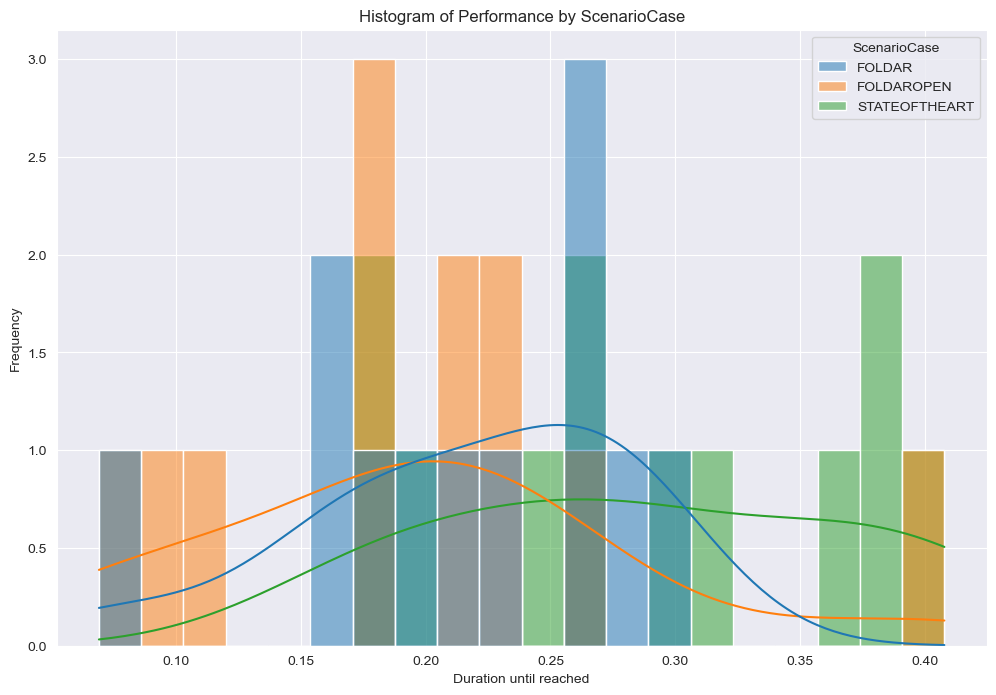

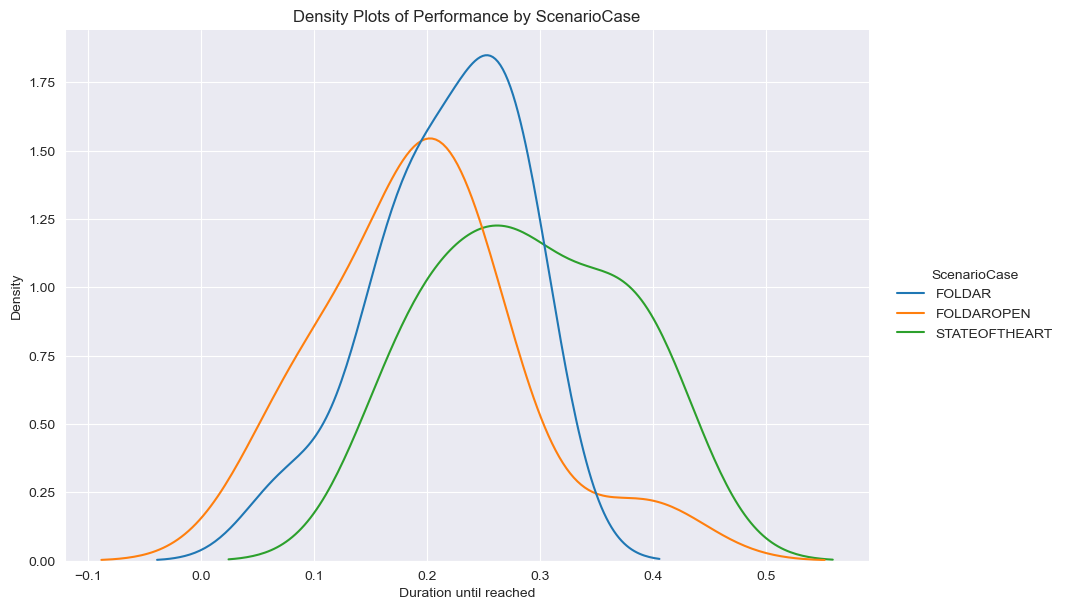

In [8]:
#Average duration for each scenario
summary_stats = DataAverageAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataAverageAggregated.groupby('ScenarioCase')[["ObjectDistance"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(combined_output)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataAverageAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Performance by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataAverageAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Performance by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.916252 | p-value: 0.256370
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.931005 | p-value: 0.390888
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.927253 | p-value: 0.351905


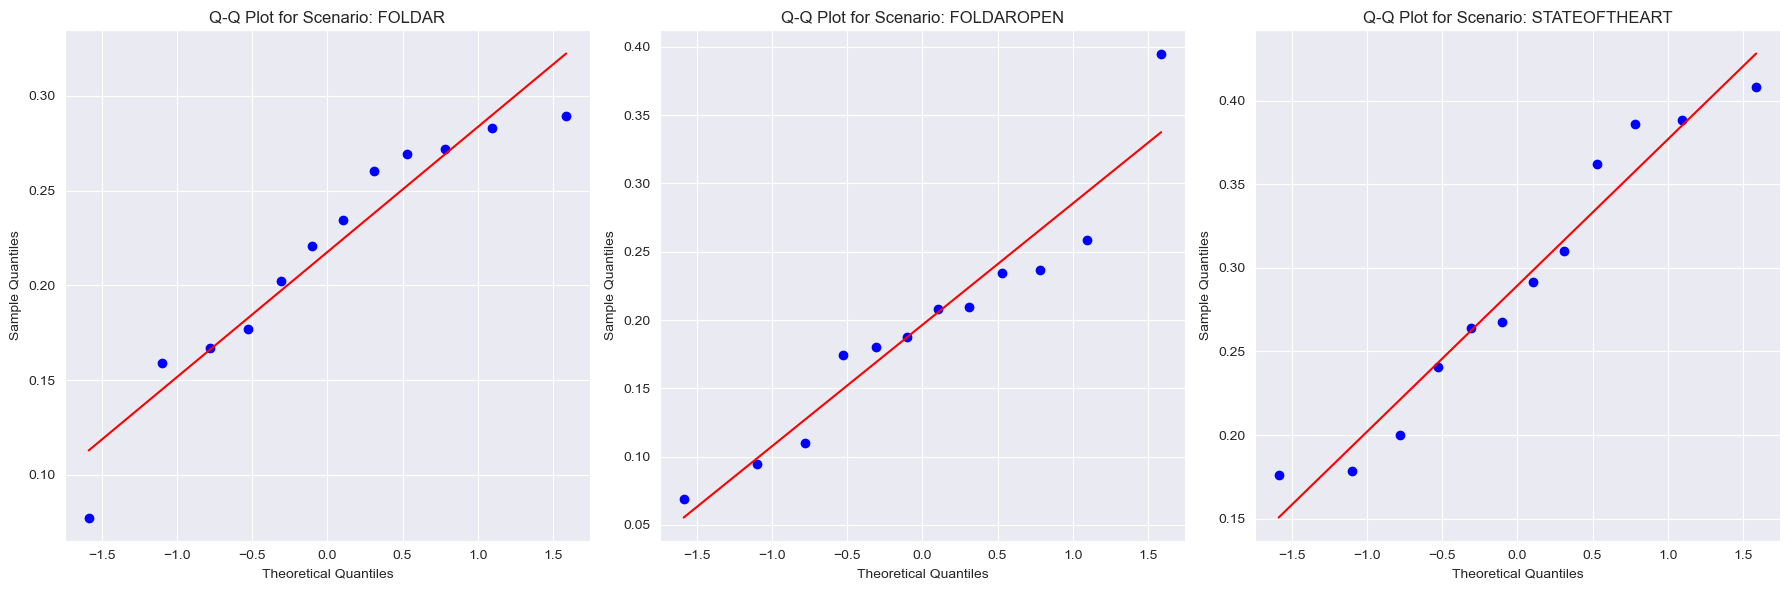

In [9]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataAverageAggregated['ScenarioCase'].unique():
    data_scenario = DataAverageAggregated.loc[DataAverageAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.6f} | p-value: {p_value:.6f}")

# Get unique scenarios
scenarios = DataAverageAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataAverageAggregated.loc[DataAverageAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Mauchlys Test

In [10]:
sphericity_results = pg.sphericity(DataAverageAggregated, dv=tested_variable, within='ScenarioCase',
                                   subject=observed_group, method='mauchly', alpha=0.05)

header = f"{'Spher':<10} {'W':<15} {'Chi2':<15} {'Dof':<10} {'P-Value':<15}"
print("\nMauchly's Test for Sphericity Results:")
print(header)
print("-" * len(header))

row = f"{str(sphericity_results.spher):<10} " \
      f"{sphericity_results.W:<15.6f} " \
      f"{sphericity_results.chi2:<15.6f} " \
      f"{sphericity_results.dof:<10} " \
      f"{sphericity_results.pval:<15.6f}"
print(row)


Mauchly's Test for Sphericity Results:
Spher      W               Chi2            Dof        P-Value        
---------------------------------------------------------------------
True       0.661667        4.129923        2          0.126823       


# Repeated Anova


Repeated Measures ANOVA Results:

+--------------+-----------+------+------------+-----------+--------------+------------+------------+
| Source       |        SS |   DF |         MS |         F |        p-unc |        ng2 |        eps |
|--------------+-----------+------+------------+-----------+--------------+------------+------------|
| ScenarioCase | 0.0569922 |    2 | 0.0284961  |   8.67157 |   0.00167144 |   0.220085 |   0.747198 |
| Error        | 0.0722953 |   22 | 0.00328615 | nan       | nan          | nan        | nan        |
+--------------+-----------+------+------------+-----------+--------------+------------+------------+


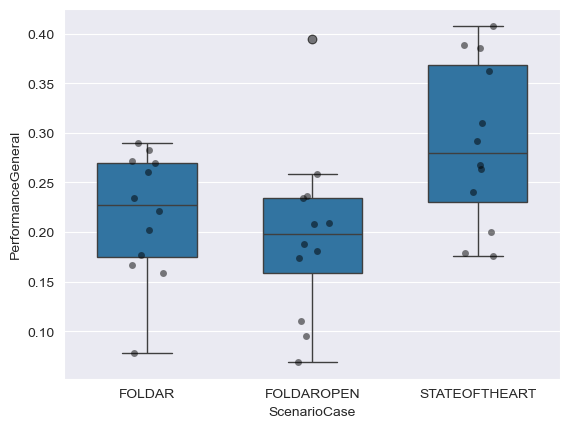

In [11]:
rm_anova = pg.rm_anova(data=DataAverageAggregated,
                       dv=tested_variable,
                       subject=observed_group,
                       within=['ScenarioCase'],
                       detailed=True)

# Print results
print("\nRepeated Measures ANOVA Results:\n")
print(tabulate(rm_anova, headers='keys', tablefmt='psql', showindex=False))

sns.boxplot(data=DataAverageAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=False)
sns.stripplot(data=DataAverageAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()

# Post-Hoc-Testing

# Pairwise T-Test

In [12]:
pairwise_results = pg.pairwise_tests(dv=tested_variable,
                                     within='ScenarioCase',
                                     subject=observed_group,
                                     data=DataAverageAggregated,
                                     padjust='holm')

print("\nPairwise Comparisons Table:")
print(tabulate(pairwise_results, headers='keys', tablefmt='psql', showindex=False))


Pairwise Comparisons Table:
+--------------+------------+---------------+----------+--------------+----------+-------+---------------+------------+------------+------------+--------+-----------+
| Contrast     | A          | B             | Paired   | Parametric   |        T |   dof | alternative   |      p-unc |     p-corr | p-adjust   |   BF10 |    hedges |
|--------------+------------+---------------+----------+--------------+----------+-------+---------------+------------+------------+------------+--------+-----------|
| ScenarioCase | FOLDAR     | FOLDAROPEN    | True     | True         |  1.02558 |    11 | two-sided     | 0.327116   | 0.327116   | holm       |  0.446 |  0.269785 |
| ScenarioCase | FOLDAR     | STATEOFTHEART | True     | True         | -3.8186  |    11 | two-sided     | 0.00285004 | 0.00855012 | holm       | 16.625 | -0.936983 |
| ScenarioCase | FOLDAROPEN | STATEOFTHEART | True     | True         | -3.16389 |    11 | two-sided     | 0.00901628 | 0.0180326  | hol

State of the Art is more precise and needs less distance to achieve the goal. Here, FoldAR is in a disadvantage when it comes to precise tasks and moving the object as little as possible.